Plot the increase in magnetisation relative to the uniform baseline for different Ising influence strategies.

Created on 27/09/20

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib
import pylab
import itertools

In [2]:
#eval_data = pd.read_csv('Data/Pokec_control_eval_data_new.csv')
eval_data = pd.read_csv('Data/Pokec_control_eval_data_positive.csv')
eval_data

,Unnamed: 0,control,magnetisation,mag_se,beta_factor,gradient
0,0,no con,0.714841,0.000018,8.0,1.0
1,1,unif,0.735960,0.000013,8.0,1.0
2,2,full,0.750625,0.000008,8.0,1.0
3,3,block,0.732780,0.000018,8.0,1.0
4,4,sv,0.740493,0.000008,8.0,1.0
...,...,...,...,...,...,...
1045,2,full,0.561538,0.000009,8.0,10.0
1046,3,block,0.543853,0.000030,8.0,10.0
1047,4,sv,0.549544,0.000008,8.0,10.0
1048,5,nc,0.540719,0.000016,8.0,10.0


In [3]:
control_names = ['block','full','nc','sv','snapshot']

In [4]:
beta_choice = 8.0
eval_data = eval_data.loc[eval_data['beta_factor']==beta_choice]
eval_data['Sample_index'] = eval_data.reset_index().reset_index().groupby(by=['control','gradient','beta_factor'])['level_0'].transform(lambda x: x.rank())

pivotted = pd.pivot_table( eval_data , values=['magnetisation'],columns=['control'] ,index=['beta_factor','gradient','Sample_index'],aggfunc={'magnetisation':np.mean} ).reset_index()
pivotted.columns=pivotted.columns.map('_'.join)
for k in control_names :
    pivotted[f"markup_{k}"] = pivotted[f'magnetisation_{k}'] - pivotted['magnetisation_unif']

grouped = pivotted.groupby(['beta_factor_','gradient_']).agg({f'markup_{k}':[np.mean,stats.sem] for k in control_names}).reset_index()
grouped.columns=grouped.columns.map('_'.join)
grouped.head()

,beta_factor__,gradient__,markup_block_mean,markup_block_sem,markup_full_mean,markup_full_sem,markup_nc_mean,markup_nc_sem,markup_sv_mean,markup_sv_sem,markup_snapshot_mean,markup_snapshot_sem
0,8.0,1.0,-0.000468,0.001442,0.015386,0.001343,-0.000035,0.001653,0.000687,0.001583,0.001745,0.001094
1,8.0,2.0,0.000198,0.001390,0.015235,0.001485,0.002540,0.001046,0.001559,0.001304,-0.001191,0.000895
2,8.0,3.0,0.005088,0.001030,0.018833,0.000989,0.006589,0.000881,0.004724,0.001064,0.004480,0.001464
3,8.0,4.0,0.005934,0.001020,-0.728206,0.001514,0.007722,0.001871,0.005176,0.001242,0.004319,0.001485
4,8.0,5.0,0.008193,0.001271,0.025603,0.001023,0.008102,0.001024,0.005639,0.001269,0.008988,0.001055


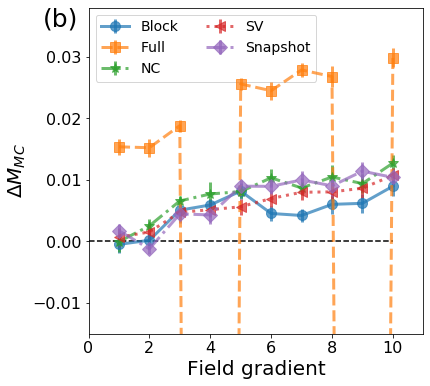

In [5]:
gradient = list(grouped['gradient__'])

# Select colours scheme:
cmap = pylab.cm.get_cmap("tab10", 6)    # PiYG
#hex_codes = [matplotlib.colors.rgb2hex(cmap(i)[:3]) for i in  range(cmap.N)]
hex_codes  = [matplotlib.colors.rgb2hex(pal) for pal in  sns.color_palette()]
col= itertools.cycle(tuple(hex_codes))
marker_styles = itertools.cycle(('o','s','*','<',"D","P"))
line_styles = itertools.cycle(('-', '--', '-.', ':','-.'))


def name_map(label) :
    """
    Upper case SV and NC.
    
    .title() to other labels
    """
    if len(label) < 3 :
        return label.upper()
    else :
        return label.title()

fig,ax=plt.subplots(figsize=(6,6))

for con in control_names :
    mean_markup = list(grouped[f'markup_{con}_mean'])
    sem_markup = list(grouped[f'markup_{con}_sem'])
    col_current=next(col)
    plt.errorbar(gradient,mean_markup,yerr=sem_markup,label=name_map(con)
                 ,mfc=f'{col_current}',mec=f'{col_current}',
                 color=f'{col_current}',
                 marker=f'{next(marker_styles)}',
                linestyle=f'{next(line_styles)}',alpha=0.7,markersize=10,lw=3.0)

plt.plot([0,10],[0,0],'k--')

plt.xlabel("Field gradient",fontsize=20)
plt.ylabel("$\Delta M_{MC}$",fontsize=20 )
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
#plt.legend(fontsize=14,ncol=2,loc='upper left')
ax.legend(fontsize=14,ncol=2,loc='upper left').set_zorder(0)
plt.xlim(0,11)
plt.ylim(-0.015,0.038)

plt.text(-1.5,0.035,'(b)',fontsize=25)

plt.savefig(f"Plots/Pokec_markup_as_grad_beta_{beta_choice}_errors_positive".replace('.','-') + ".jpg",bbox_inches='tight')

In [11]:
single_gradient=eval_data.loc[eval_data['gradient']==5]
single_gradient

,Unnamed: 0,control,magnetisation,mag_se,beta_factor,gradient,Sample_index
420,0,no con,0.683346,0.000009,8.0,5.0,1
421,1,unif,0.713330,0.000021,8.0,5.0,1
422,2,full,0.733702,0.000019,8.0,5.0,1
423,3,block,0.726083,0.000012,8.0,5.0,1
424,4,sv,0.709319,0.000013,8.0,5.0,1
...,...,...,...,...,...,...,...
520,2,full,0.730823,0.000030,8.0,5.0,15
521,3,block,0.716614,0.000011,8.0,5.0,15
522,4,sv,0.715065,0.000024,8.0,5.0,15
523,5,nc,0.719338,0.000008,8.0,5.0,15


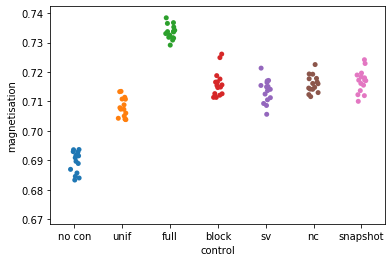

In [12]:
sns.stripplot(data=single_gradient,x='control',y='magnetisation')